# Analyse Noise Complaints in NYC

### Load Libraries

In [105]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import create_set_cmap
import matplotlib.pyplot as plt
%matplotlib inline

### Load the filtered dataset

In [3]:
# Load it into a Dataframe using pandas
path = '../data/311_filtered.csv'
df = pd.read_csv(path)
df.head()

Created Date             Closed Date Agency  \
0  11/07/2011 04:02:50 PM  11/07/2011 05:45:14 PM   NYPD   
1  11/07/2011 11:53:37 AM  11/07/2011 03:14:40 PM   NYPD   
2  11/07/2011 05:53:47 PM  11/07/2011 06:13:21 PM   NYPD   
3  11/07/2011 07:47:15 PM  11/08/2011 12:13:05 AM   NYPD   
4  11/07/2011 09:11:39 PM  11/08/2011 04:53:53 AM    DOT   

            Complaint Type                      Descriptor    Location Type  \
0         Blocked Driveway                       No Access  Street/Sidewalk   
1          Illegal Parking  Double Parked Blocking Traffic  Street/Sidewalk   
2  Noise - Street/Sidewalk                Loud Music/Party  Street/Sidewalk   
3          Illegal Parking        Unauthorized Bus Layover  Street/Sidewalk   
4        Broken Muni Meter                      No Receipt           Street   

     Borough   Latitude  Longitude  
0   BROOKLYN  40.609242 -73.982821  
1   BROOKLYN  40.692605 -73.997137  
2  MANHATTAN  40.762290 -73.986106  
3  MANHATTAN  40.726866 -73.979908  
4  MANHATTAN  40.759064 -73.978450

### Filter noise related data

In [4]:
# Keep noise related data in a seperate dataframe
df_noise = df[df['Complaint Type'].str.contains("Noise")]

In [5]:
# Unique noise types
df_noise['Complaint Type'].unique()

array(['Noise - Street/Sidewalk', 'Noise - Residential', 'Noise Survey',
       'Noise - Vehicle', 'Noise - Commercial', 'Noise - Helicopter',
       'Noise - Park', 'Noise - House of Worship', 'Collection Truck Noise'], dtype=object)

In [6]:
# Create a frequency table in order to plot
noise_freq = df_noise['Complaint Type'].groupby(df_noise['Complaint Type']).count().sort_values(ascending=1).reset_index(name='count')
noise_freq

Complaint Type   count
0    Collection Truck Noise    1112
1  Noise - House of Worship    5008
2        Noise - Helicopter    5259
3              Noise Survey   10141
4              Noise - Park   16119
5           Noise - Vehicle   83122
6   Noise - Street/Sidewalk  179989
7        Noise - Commercial  182518
8       Noise - Residential  921438

We should better keep the noise related complain types with the highest frequency as the rest will not make any difference in the end. Thus,

In [7]:
# Save the five most significant noise incidents in a list
noise_list = list(noise_freq['Complaint Type'].values)[-5:]
noise_list

['Noise - Park',
 'Noise - Vehicle',
 'Noise - Street/Sidewalk',
 'Noise - Commercial',
 'Noise - Residential']

In [8]:
# Re-filter the data
df_noise = df_noise[df_noise['Complaint Type'].isin(noise_list)]

In [9]:
# Check unique values
df_noise['Complaint Type'].unique()

array(['Noise - Street/Sidewalk', 'Noise - Residential', 'Noise - Vehicle',
       'Noise - Commercial', 'Noise - Park'], dtype=object)

Now we are sure that the correct noise complaints are filtered. Later we will create a YEAR column to check noise complains per year in a barplot and check the trend.

In [10]:
# Create a function that gets the year of a datetime string
def getYear(s):
    first_split = s.split(' ')[0]
    return int(first_split.split('/')[-1])

In [11]:
# Now create a new column named year and store the values of the above function
df_noise['Created Year']= df_noise['Created Date'].apply(lambda x: getYear(x))

In [12]:
# List the noise complains per year
noise_freq_time = df_noise.groupby('Created Year')['Created Year'].count().reset_index(name='count').sort_values(by='Created Year', ascending=1)
noise_freq_time

Created Year   count
0          2010      13
1          2011   23394
2          2012  179342
3          2013  217395
4          2014  283533
5          2015  323965
6          2016  284492
7          2017   71052

### Plot noise complains over time

Let's check the above table in a barplot

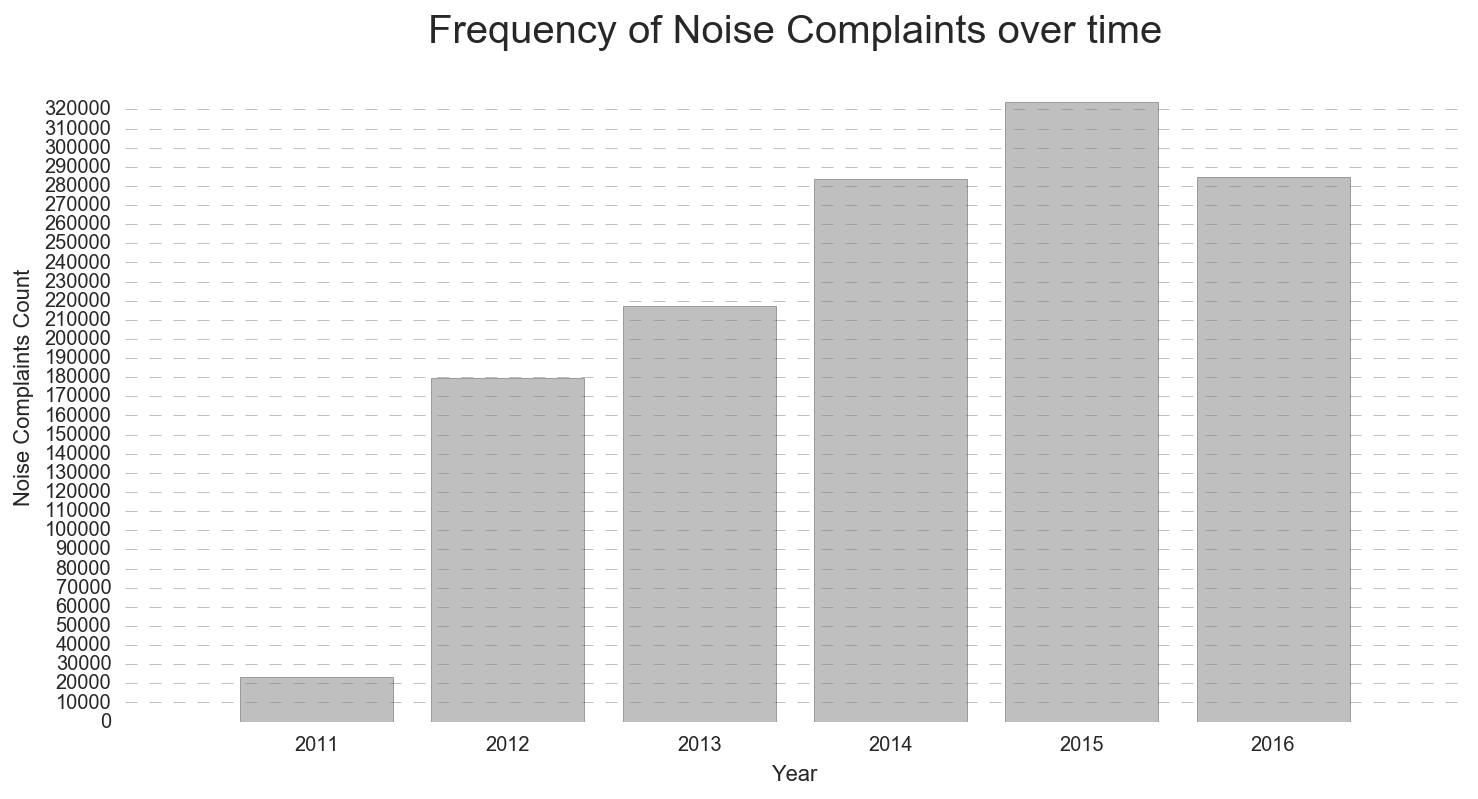

In [63]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# Drop 2017 and 2010 as it could be misleading as only few values for the first two months exist
noise_freq_time = noise_freq_time[(noise_freq_time['Created Year'] != 2017) & (noise_freq_time['Created Year'] != 2010)]

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y axes
x = noise_freq_time['Created Year']
y = noise_freq_time['count']

# Give indeces to complaints
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(12, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y, align='center', color='grey', alpha=.5)

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(round(min(y),-5), round(max(y),-5)+30000, 10000))
plt.xticks(x_pos, x)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Noise Complaints Count")
plt.xlabel("Year")
plt.title("Frequency of Noise Complaints over time",fontsize=20)

# Show the barplot
plt.show()

It is obvious that there was a constant raise in noise complains since 2011 until 2015, where this type of complains started to decline. Let's create the same **barplot but this time split by noise complain category** and see all 5 category barplots.

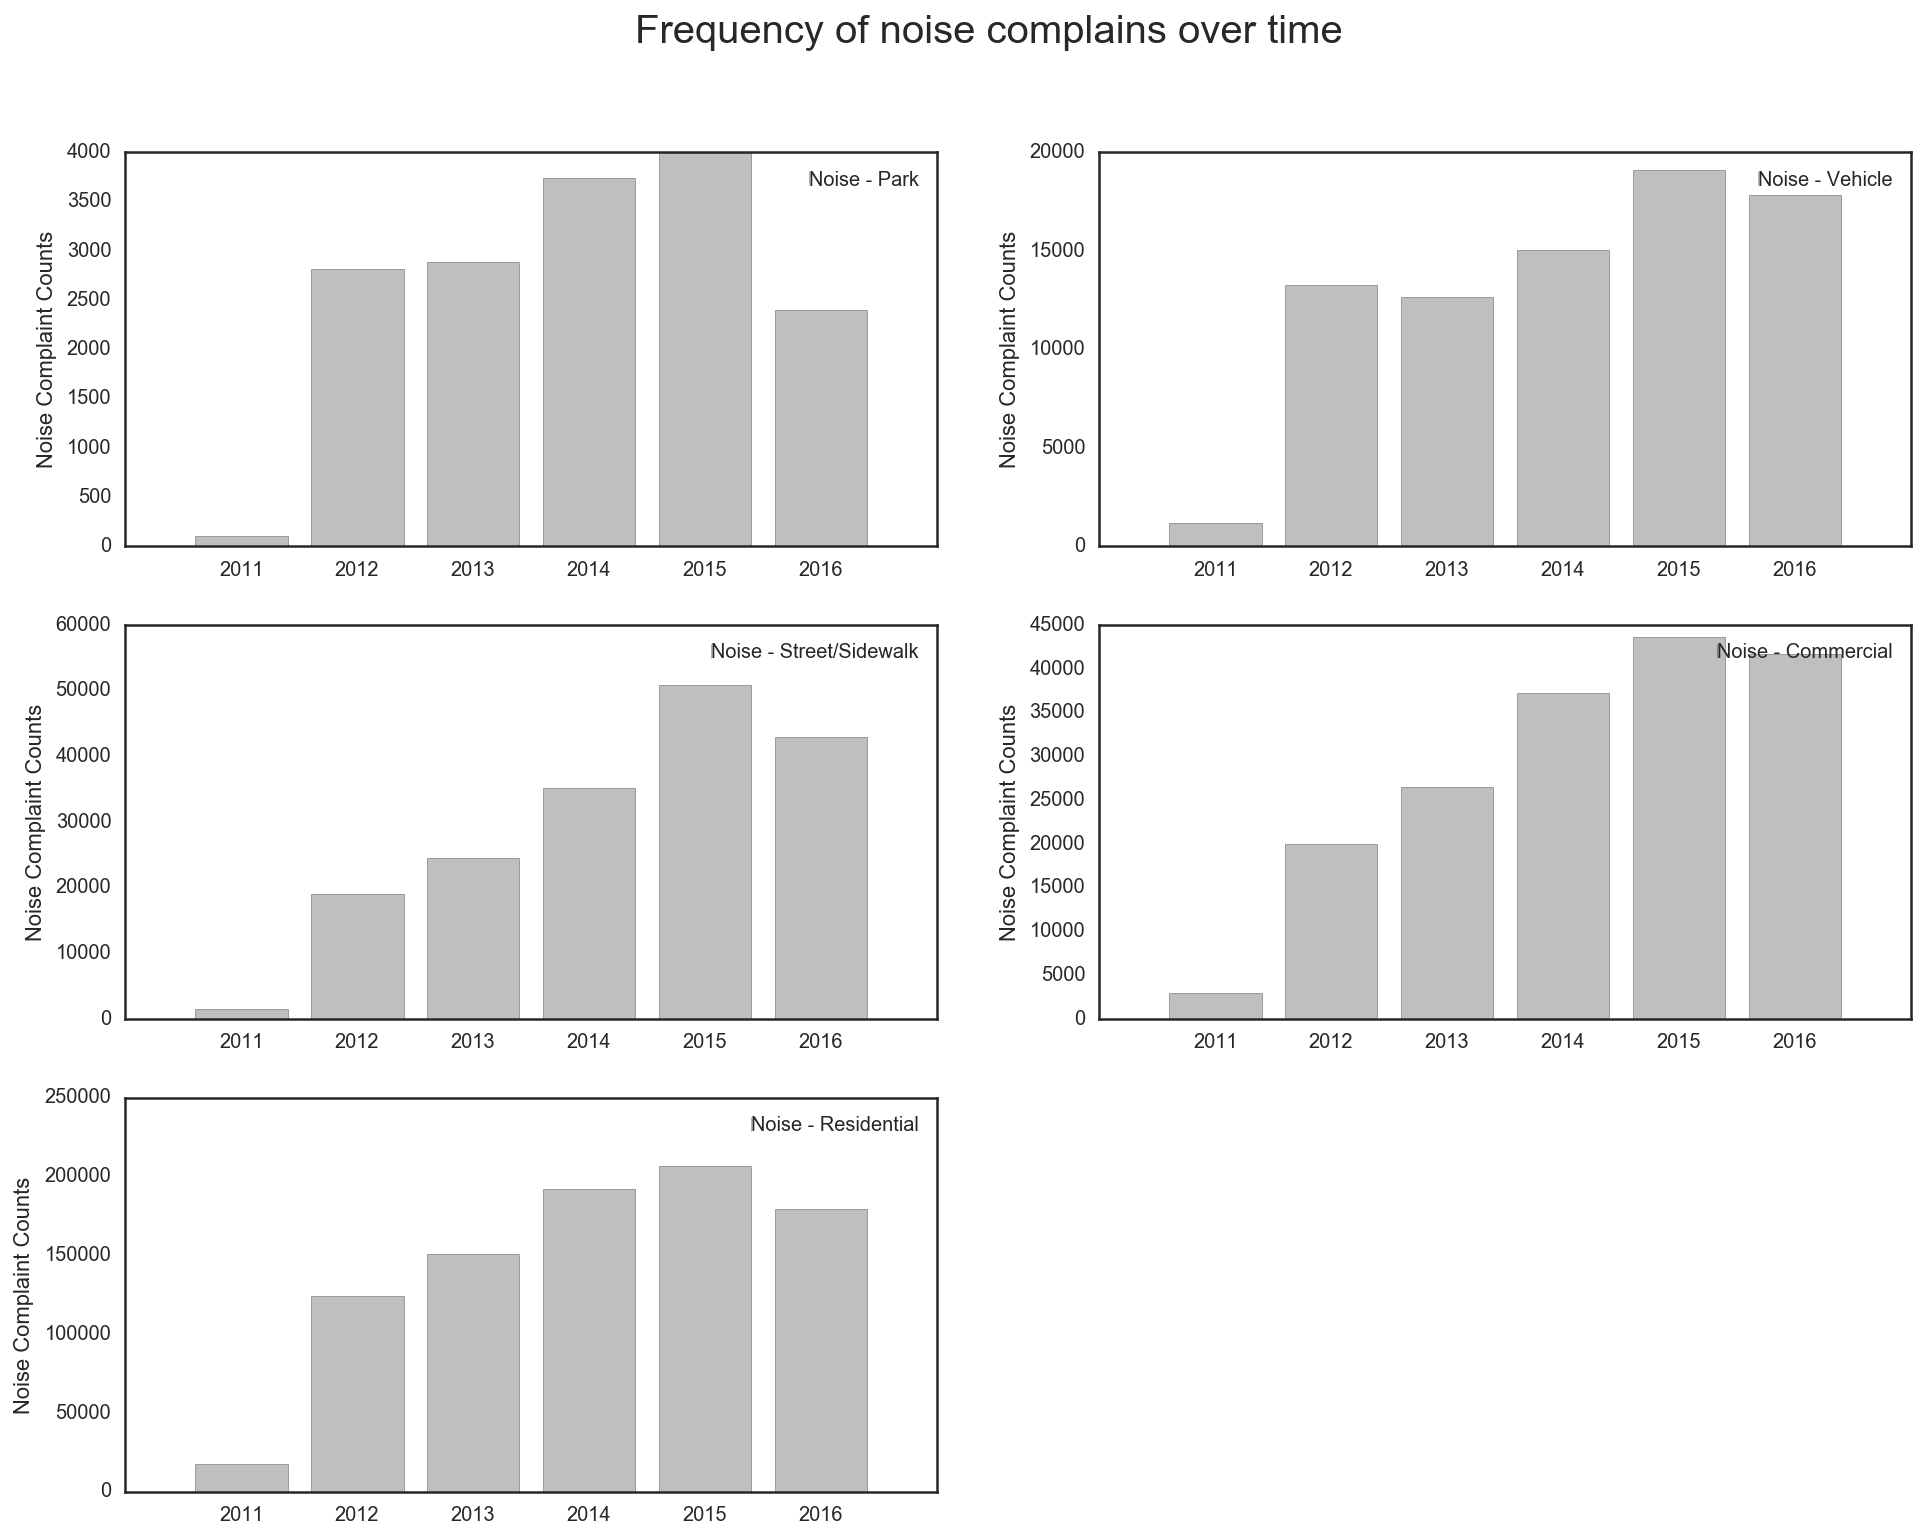

In [59]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(16, 12))
plt.suptitle('Frequency of noise complains over time',fontsize=20)
for index, complain in enumerate(noise_list):
    # Create a matrix of subplots with 3 rows and two columns
    plt.subplot(3, 2, index + 1)

    # Create a sub-df for each category
    temp_df = df_noise[df_noise['Complaint Type'] == complain]

    # Drop 2017 and 2010 as it could be misleading as only few values for the first two
    # months exist
    temp_df = temp_df[(temp_df['Created Year'] != 2017) & (temp_df['Created Year'] != 2010)]

    # Count frequency of complaint occurence
    occurence = temp_df.groupby('Created Year')['Created Year'].count().reset_index(
        name='count').sort_values(by='Created Year', ascending=1)

    # Assign x and y values
    x = occurence['Created Year']
    y = occurence['count']

    # Give indeces to complaints
    x_pos = np.arange(len(x))
    
    plt.bar(x_pos, y, align='center', alpha=.5, color='grey', label=complain)
    plt.xticks(x_pos, x)
    plt.ylabel("Noise Complaint Counts")
    plt.legend(loc='upper right', frameon=False,
               handlelength=0, handletextpad=0)

# Show the barplot
plt.show()

Let's examine the **hours** with the highest noise complains in NYC.

In [44]:
# Create function that converts 12-hour date str to 24-hour date str
def convert12to24(s):
    # Set date formats
    initial_format = "%m/%d/%Y %I:%M:%S %p"
    second_format = "%m/%d/%Y %H:%M:%S"
    # Convert from str to datetime
    first_step = datetime.strptime(s,initial_format)
    # And then back to str
    second_step = datetime.strftime(first_step,second_format)
    return second_step

In [29]:
# Create a function that gets the hour
def getHour(s):
    first_split = s.split(' ')[1]
    return int(first_split.split(':')[0])

In [45]:
# Create a new column with 24-hour format to campture the a hour
df_noise['Created Date 24'] = df_noise['Created Date'].apply(lambda x: convert12to24(x))

In [51]:
# Now create a new column named hour and store the values of the above function
df_noise['Created Hour'] = df_noise['Created Date 24'].apply(lambda x: getHour(x))

In [53]:
df_noise.head(1)

Created Date             Closed Date Agency  \
2  11/07/2011 05:53:47 PM  11/07/2011 06:13:21 PM   NYPD   

            Complaint Type        Descriptor    Location Type    Borough  \
2  Noise - Street/Sidewalk  Loud Music/Party  Street/Sidewalk  MANHATTAN   

   Latitude  Longitude  Created Year  Created Hour      Created Date 24  
2  40.76229 -73.986106          2011            17  11/07/2011 17:53:47

In [55]:
# List the number of noise complaints per hour
noise_freq_hour = df_noise.groupby('Created Hour')['Created Hour'].count().reset_index(
    name='count').sort_values(by='Created Hour', ascending=1)
noise_freq_hour

Created Hour   count
0              0  151413
1              1  114921
2              2   73801
3              3   45852
4              4   30463
5              5   19441
6              6   14993
7              7   15140
8              8   16936
9              9   19041
10            10   21264
11            11   23291
12            12   25868
13            13   28087
14            14   30212
15            15   32945
16            16   36592
17            17   42624
18            18   51622
19            19   64536
20            20   82758
21            21  107886
22            22  153419
23            23  180081

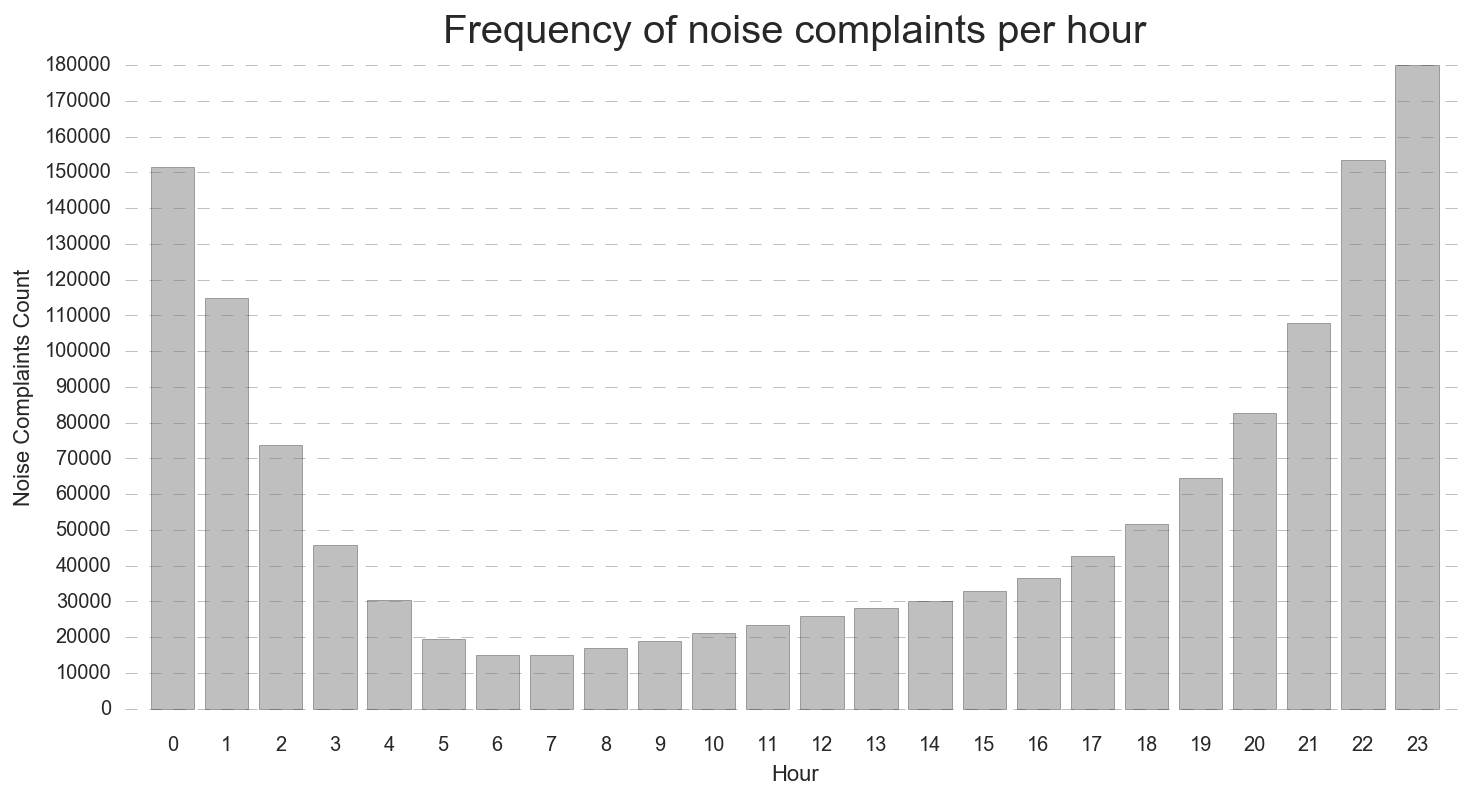

In [60]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y values
x = noise_freq_hour['Created Hour']
y = noise_freq_hour['count']

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(12, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x, y, align='center', color='grey', alpha=.5)

# Create ticks
plt.xticks(range(0, 24, 1))
plt.yticks(np.arange(round(min(y),-5), round(max(y),-5)+30000, 10000))
plt.margins(0.02)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Noise Complaints Count")
plt.xlabel("Hour")
plt.title("Frequency of noise complaints per hour",fontsize=20)

# Show the barplot
plt.show()

We see that people are bothered by noise usually during sleeping hours. **Since 20 at night to 02** in the morning is the time span with the most complaints. Last step is to **split the same plot per noise complaint type** as we did before for years.

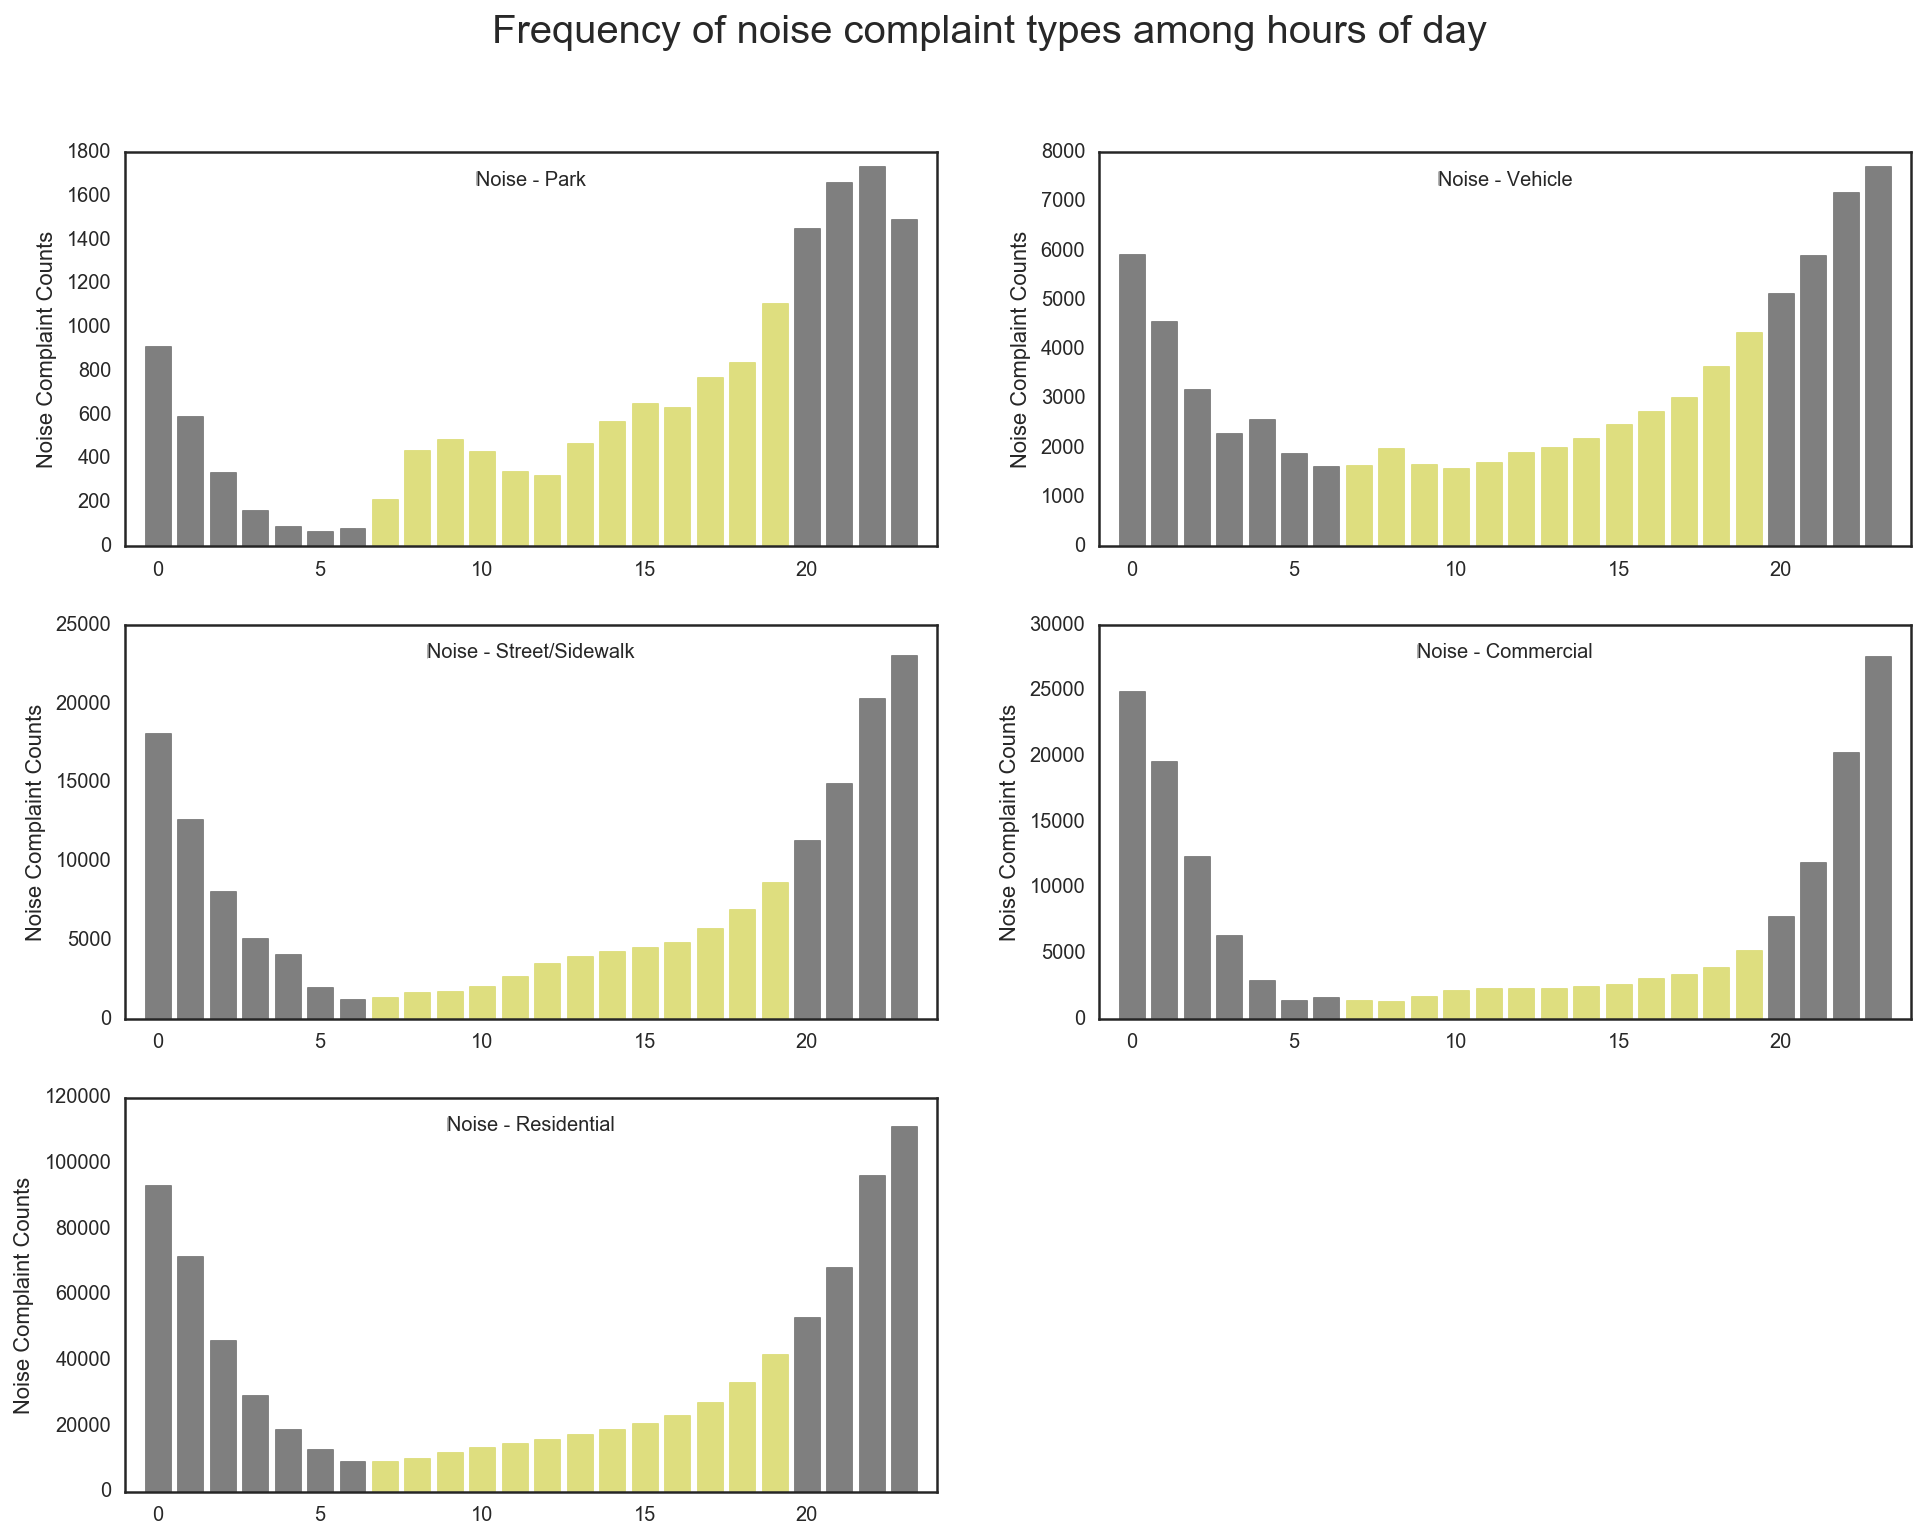

In [61]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize = (16,12))
plt.suptitle('Frequency of noise complaint types among hours of day',fontsize=20)
for index, complain in enumerate(noise_list):
    # Create a matrix of subplots with 3 rows and two columns
    plt.subplot(3, 2, index + 1)
     
    # Create a sub-df for each category
    temp_df = df_noise[df_noise['Complaint Type'] == complain]
    
    # Drop 2017 and 2010 as it could be misleading as only few values for the first two
    # months exist
    temp_df = temp_df[(temp_df['Created Year'] != 2017) & (temp_df['Created Year'] != 2010)]
    
    # Count frequency of complaint occurence
    occurence = temp_df.groupby('Created Hour')['Created Hour'].count().reset_index(name='count').sort_values(by='Created Hour', ascending=1)
    
    # Assign x and y values
    x = occurence['Created Hour']
    y = occurence['count']

    # Give indeces to complaints
    x_pos = np.arange(len(x))
    
    bars = plt.bar(x_pos,y,align='center',alpha=.5, color='grey',label=complain)
    # Distinguise day hours with different color 
    for i,bar in enumerate(bars):
        if (i>=0 and i<7) or i>=20:
            bar.set_color('k')
        else:
            bar.set_color('y')
        
    plt.xticks(np.arange(0,24,5))
    plt.ylabel("Noise Complaint Counts")
    plt.legend(loc='upper center',frameon=False,handlelength=0, handletextpad=0)
    plt.xlim(-1,24)
    
# Show the barplot
plt.show()

It is obviously seen that all noise complaint types have the same pattern. Less complaints in day hours (yellow bars) and more in night hours (gray bars).

### Predict the borough of noise complaints using Decision Tree Classifier

In [9]:
# Encode categorical variables to digits
le = LabelEncoder()
X = le.fit_transform(df_noise['Complaint Type'])  
Y = le.fit_transform(df_noise['Borough'])

In [10]:
# Split training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [11]:
#Train the decision tree classifier
clf = tree.DecisionTreeClassifier()
#The scikit-learn fit function needs a list of lists as input even if the nested lists have length 1
clf = clf.fit(X_train[:,None], Y_train[:,None])
# Predict the testing features
pred = clf.predict(X_test[:,None])

We re-convert the numerical values of Y_test and pred to categorical, since we'll need them for the next step.


In [12]:
pred = le.inverse_transform(pred)
Y_test_inv = le.inverse_transform(Y_test)

We calculate the fraction of correct predictions.

In [13]:
print 'Fraction of correct predictions : %.2f%%' % (clf.score(X_test[:,None],Y_test[:,None])*100)

Fraction of correct predictions : 33.92%


Which means that our classifier is not that reliable to predict the correct borough if we only fit it with the noise type. But **if we restrict the training/prediction to single boroughs** (for example, predicting MANHATTAN vs. all other districts) we will see a different score for the classifier.

In [15]:
# Fit all boroughs into a list of unique boroughs and exclude nan boroughs
boroughs = sorted(list(set(df_noise['Borough'])))[:-1]

#Function to get the binary representation of a specific value
def get_binary_repr(value,borough):
    if value==borough:
        return borough
    return 'NOT'+borough

# Initiate PrettyTable
x = PrettyTable(field_names=['Borough','Correct Prediction'])
for borough in boroughs:
    df_binary_boroughs = df_noise
    df_binary_boroughs['Borough_Bin'] = df_binary_boroughs['Borough'].apply(lambda x: get_binary_repr(x,borough))

    # Split training and testing data (N.B. X is the same as before)
    Y_new = df_binary_boroughs['Borough_Bin']
    Y_new = le.fit_transform(Y_new)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_new, test_size=0.1, random_state=0)
    
    #Train classifier and predict
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train[:,None], Y_train[:,None])

    #Calculate fraction of correct predictions
    x.add_row([borough,str(clf.score(X_test[:,None],Y_test[:,None])*100)[:5]+'%'])
    
print x

+---------------+--------------------+
|    Borough    | Correct Prediction |
+---------------+--------------------+
|     BRONX     |       79.17%       |
|    BROOKLYN   |       70.03%       |
|   MANHATTAN   |       70.78%       |
|     QUEENS    |       82.55%       |
| STATEN ISLAND |       97.46%       |
+---------------+--------------------+


This is a pretty cool picture. We can easily predict and rely in our prediction that a specific noise complaint will occur in a specific borough. But let's **plot on a map** all noise complaints in different color and see why **STATEN ISLAND** borough is so predictable in terms of noise.

### Plot noise complains on map (only 2016)

In [64]:
# Create a new df only for 2016
df_noise_2016 = df_noise[df_noise['Created Year']==2016]
df_noise_2016.head()

Created Date             Closed Date Agency  \
2839  12/21/2016 06:34:34 AM  12/21/2016 10:32:42 AM   NYPD   
6090  12/22/2016 12:53:01 AM  12/22/2016 05:22:58 AM   NYPD   
6315  12/21/2016 02:22:48 AM  12/21/2016 08:13:24 AM   NYPD   
7506  12/21/2016 10:27:27 AM  12/21/2016 09:08:43 PM   NYPD   
7510  12/21/2016 10:12:29 PM  12/21/2016 10:53:49 PM   NYPD   

          Complaint Type        Descriptor        Location Type    Borough  \
2839  Noise - Commercial  Banging/Pounding     Store/Commercial  MANHATTAN   
6090     Noise - Vehicle     Engine Idling      Street/Sidewalk  MANHATTAN   
6315     Noise - Vehicle     Engine Idling      Street/Sidewalk   BROOKLYN   
7506  Noise - Commercial  Loud Music/Party  Club/Bar/Restaurant  MANHATTAN   
7510  Noise - Commercial  Loud Music/Party  Club/Bar/Restaurant  MANHATTAN   

       Latitude  Longitude  Created Year  Created Hour      Created Date 24  
2839  40.729656 -74.003850          2016             6  12/21/2016 06:34:34  
6090  40.744095 -73.982089          2016             0  12/22/2016 00:53:01  
6315  40.716796 -73.960489          2016             2  12/21/2016 02:22:48  
7506  40.853686 -73.930538          2016            10  12/21/2016 10:27:27  
7510  40.763622 -73.997015          2016            22  12/21/2016 22:12:29

Firstly, we should check for outliers in the coordinates dataset.

In [65]:
#Checking if the data is clean enough (no outliers)
lats = [float(el) for el in list(df_noise_2016['Latitude'])]
longs = [float(el) for el in list(df_noise_2016['Longitude'])]
print 'Latitudes:',set([round(el) for el in lats])
print 'Longitudes:',set([round(el) for el in longs])

Latitudes: set([40.0, 41.0])
Longitudes: set([-74.0])


Longs and Lats seem normal with no outliers. Now we are ready to plot each complain as a point on a map. But before that, we should **create a dictionary**(mandatory for the **geoplotlib library**) with two keys(lat and lon) and two lists as values of each key(lists of coordinates).

In [66]:
# Create dictionary and put each complaint's coordinates as a seperate key,value pair
geo_dict = {}
for complaint in noise_list:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_noise_2016[df_noise_2016['Complaint Type']==complaint]['Latitude'])],
                             "lon": [float(el) for el in list(df_noise_2016[df_noise_2016['Complaint Type']==complaint]['Longitude'])]}
    geo_dict[complaint] = geo_data_for_plotting

And now we are fully ready for plotting the complains with different color per noise complain type on a map.

In [86]:
#Let's define a function for plotting the dot map, as it will be used later
def dot_plot(geo_dict,size):
    colors = ['white', 'black', 'red', 'green', 'blue']

    for i,complaint in enumerate(noise_list):
        # Create a legend
        print '%s\t\t ----->\t\t%d observations\t\t ----->\t\t%s' % (colors[i],len(geo_dict[complaint]['lon']),complaint)
        # Fit the map with dots
        geoplotlib.dot(geo_dict[complaint], color=colors[i], point_size=size)

    # Create an BoundigBox for the limits of the map
    bbox = BoundingBox(north=max(geo_dict[complaint]['lat']),
                       west=min(geo_dict[complaint]['lon']),
                       south=min(geo_dict[complaint]['lat']),
                       east=max(geo_dict[complaint]['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()
    
dot_plot(geo_dict,.8)

white		 ----->		2403 observations		 ----->		Noise - Park
black		 ----->		17848 observations		 ----->		Noise - Vehicle
red		 ----->		42956 observations		 ----->		Noise - Street/Sidewalk
green		 ----->		41712 observations		 ----->		Noise - Commercial
blue		 ----->		179573 observations		 ----->		Noise - Residential


So maybe the reason why the **STATEN ISLAND** is so well predictable is that as seen on the map, it is not that dense meaning that there are not a lot of complains related to noise in this borough.

### Predict the borough of noise complaints using KNN classifier

According to the above, the classifier will more likely fit those dots with high density(blue - Residential Noise) together with those dots with lower density(black - Noise Park). Below we get a **balanced dataset** by taking an equal number of random samples for each category:

In [72]:
num_samples = 2000 #Number of random samples to extract

# Randomly extract a balanced number of samples
df_noise_2016_bal = pd.DataFrame(columns = ['Complaint Type','Longitude','Latitude'])
for complaint in noise_list:
    sample = df_noise_2016[df_noise_2016['Complaint Type']==complaint].sample(n=num_samples).filter(items=['Complaint Type','Longitude','Latitude'])
    df_noise_2016_bal = pd.concat([sample,df_noise_2016_bal])

After creating the **balanced dataset** is should be sum up to 10000 lines(2000 lines for each of the 5 noise type complaints). Let's be sure that the sampling worked correctly. 

In [73]:
len(df_noise_2016_bal)

10000

Let's plot the **balanced map** and check the distribution of points before fitting the classifier. Firstly we should create a new balanced dictionary for the **geoplotlib** library.

In [77]:
# Create a dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict_bal = {}
for complaint in noise_list:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_noise_2016_bal[df_noise_2016_bal['Complaint Type']==complaint]['Latitude'])],
                             "lon": [float(el) for el in list(df_noise_2016_bal[df_noise_2016_bal['Complaint Type']==complaint]['Longitude'])]}
    geo_dict_bal[complaint] = geo_data_for_plotting

In [87]:
dot_plot(geo_dict_bal,2)

white		 ----->		2000 observations		 ----->		Noise - Park
black		 ----->		2000 observations		 ----->		Noise - Vehicle
red		 ----->		2000 observations		 ----->		Noise - Street/Sidewalk
green		 ----->		2000 observations		 ----->		Noise - Commercial
blue		 ----->		2000 observations		 ----->		Noise - Residential


Now we are ready to fit the classifier with the balanced dataset. But in order to distinguise the clusters that will be created from the classifiers we should first create an approximately **square grid** of point that runs over NYC. The size grid will be **100x100**(10000 points in total). 

In [92]:
def grid_creator(df_data,grid_size):
    '''Create a grid of XxY'''
    # Define grid size
    grid_size = grid_size

    #Generating all the coordinates of the points contained in the grid
    min_lat = min(df_data['Latitude'])
    max_lat = max(df_data['Latitude'])
    min_lon = min(df_data['Longitude'])
    max_lon = max(df_data['Longitude'])
    all_lats = np.arange(min_lat,max_lat,(max_lat-min_lat)/grid_size)
    all_longs = np.arange(min_lon,max_lon,(max_lon-min_lon)/grid_size)

    #List of tuples representing points, generated combining all possible values of latitudes/longitudes
    all_points = set() #Created as set, to be sure it won't contain duplicates
    for lat in all_lats:
        for lon in all_longs:
            all_points.add((lat,lon)) #each coordinate saved as a tuple
    all_points = list(all_points)

    all_grid_points = {'lat': [el[0] for el in all_points],
                       'lon':[el[1] for el in all_points]}
    return all_grid_points,all_points

In [93]:
all_grid_points,all_points = grid_creator(df_noise_2016,100)

Below we plotted just an overview of what does the grid look like (before the classification, only raw coordinate points, to make sure it was as expected):

In [102]:
geoplotlib.dot(all_grid_points, color='black', point_size=2)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(all_grid_points['lat'])-0.1,
                   west=min(all_grid_points['lon'])+0.1,
                   south=min(all_grid_points['lat'])+0.1,
                   east=max(all_grid_points['lon'])-0.1)
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

As it's shown below, we used Object Oriented Programming for Python to create a Layer class, whose concern is to display the title on each plot and plot complex data. We fit the **KNN classifier** inside the invalidate() method and according to the output provided by the prediction we draw each point of the grid with the correct color.
For each number of neighbors we plot the colored grid, in order to see what does this parameter affect concerning the model.

In [141]:
class KNeighbors_Layer(BaseLayer):

    def __init__(self, data,k,all_grid_points):
        self.data = data #Is the balanced dataframe
        self.k = k # number of neighbors
        self.all_grid_points = all_grid_points #All the coordinate of the grid points

    def invalidate(self, proj):
        self.painter = BatchPainter() # initilizes the painter
        
        # Train the KNN classifier
        features = np.array(self.data[['Latitude','Longitude']]) # Notice that X,Y are reverted by default in the original data frame
        labels = np.array(self.data['Complaint Type'])
        clf = KNeighborsClassifier(n_neighbors=self.k)
        clf.fit(features, labels)
        print 'Neighbors # %d \t\t ----->\t\t %.2f%% ' % (self.k,(clf.score(features, labels)*100))
        
        #Prepare the grid points to predict, building matrix
        x, y = proj.lonlat_to_screen(self.all_grid_points['lon'], self.all_grid_points['lat'])
        #Used column stack to concatenate by columns the two arrays and create a 2D array
        grid_points_matrix = np.column_stack((self.all_grid_points['lat'],self.all_grid_points['lon']))
        Z = clf.predict(grid_points_matrix)
        
        # Create colormap per complaint type
        self.cmap = {'Noise - Park':'white','Noise - Vehicle':'black','Noise - Street/Sidewalk':'red', 
                    'Noise - Commercial': 'green', 'Noise - Residential':'blue'}
        for complaint in noise_list:
            self.painter.set_color(self.cmap[complaint])
            self.painter.points(x[Z == complaint], y[Z == complaint], 4) # paints the points according to predicted crimes
    
    # Map interaction
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        ui_manager.info('Number of neighbors : %d' % self.k)
        self.painter.batch_draw()

After the definition of the class, we finally plot the different dot maps, each one using a different number of neighbors for the classifier.

In [142]:
num_neighbors=[3,5,10,30]
colors = ['white', 'black', 'red', 'green', 'blue']

# Create Legend
print '********************************\n************ Legend ************\n********************************\n' 
for i,complaint in enumerate(noise_list):
    print '%s\t\t ----->\t\t%s community' % (colors[i],complaint)
print '---------------------------------------------------------------------\n\n'
print '*******************************************\n************ Prediction Scores ************\n*******************************************\n'

for k in num_neighbors:
    geoplotlib.add_layer(KNeighbors_Layer(df_noise_2016_bal,k,pd.DataFrame(all_grid_points)))
    geoplotlib.set_smoothing(True)
    bbox = BoundingBox(north=max(all_grid_points['lat'])-0.1,
                   west=min(all_grid_points['lon'])+0.1,
                   south=min(all_grid_points['lat'])+0.1,
                   east=max(all_grid_points['lon'])-0.1)
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()

********************************
************ Legend ************
********************************

white		 ----->		Noise - Park community
black		 ----->		Noise - Vehicle community
red		 ----->		Noise - Street/Sidewalk community
green		 ----->		Noise - Commercial community
blue		 ----->		Noise - Residential community
---------------------------------------------------------------------


*******************************************
************ Prediction Scores ************
*******************************************

Neighbors # 3 		 ----->		 71.28% 


Neighbors # 5 		 ----->		 64.13% 


Neighbors # 10 		 ----->		 56.05% 


Neighbors # 30 		 ----->		 46.77% 
